In [2]:
import pandas as pd
import numpy as  np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from sklearn.preprocessing import LabelEncoder #Convert str label into int
from warnings import filterwarnings
from textblob import TextBlob, Word
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
filterwarnings('ignore')

trainning_df= pd.DataFrame( pd.read_csv('Corona_NLP_train.csv'))
testing_df= pd.DataFrame( pd.read_csv('Corona_NLP_test.csv'))
combined_df = pd.concat([trainning_df,testing_df]).reset_index(drop = True)

# Data pre-processing

In [3]:
def pre_process(df):
    #Keep data that have sentiment
    #Remove columns that is useless
    df = df[df['Sentiment'].notna()]
    #df = df.drop(columns = ['Unnamed: 6','Unnamed: 7', 'Unnamed: 8'])
    df['TweetAt'] = pd.to_datetime(df['TweetAt'])


    #Remove weird sentiment
    df = df[df.Sentiment != ' England"']
    df = df[df.Sentiment != ' PA"']

    #Simplify multiple label into two 
#     df.replace(to_replace="Extremely Negative", value="Negative", inplace=True)
#     df.replace(to_replace="Extremely Positive", value="Positive", inplace=True)
#     df.replace(to_replace="Neutral", value="Negative", inplace=True)


    #Convert str label into int 
    le = LabelEncoder()
    df.Sentiment = le.fit_transform(df.Sentiment)

    #Convert all txt to lower case
    df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x : " ".join(x.lower() for x in x.split()))

    #s: white space; w: alphabetical character; d: number
    #Remove punctunation and numbers
    df['OriginalTweet'] = df['OriginalTweet'].str.replace('[^\s\w\d]', '')

    #Remove stopwords
    sw = stopwords.words('english')
    df['OriginalTweet']= df['OriginalTweet'].apply(lambda x : " ".join(x for x in x.split() if x not in sw))


    #Remove infrequent word
    #Use value_count to return last 500 unique words
    infrequent_word = pd.Series("".join(df['OriginalTweet']).split()).value_counts()[-2000 :]
    df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x : " ".join(x for x in x.split() if x not in infrequent_word))


    #Create new sentiment label
    sia = SentimentIntensityAnalyzer()
    df['sentiment_label'] = df['OriginalTweet'].apply(lambda x : 'pos' if sia.polarity_scores(x)['compound'] > 0 else 'neg')
    
    #Stemming using snowball stemmer
    # snowBallStemmer = SnowballStemmer("english")
    # df["OriginalTweet"] = df['OriginalTweet'].apply(lambda x: " ".join([snowBallStemmer.stem(word) for word in nltk.wordpunct_tokenize(x)]))


    #Instead of using snowball stemmer, I'm going to use Lemmatization
    #Although these two methods are similar, but lemmatization is more complicated
    #which can include more words that stemmer can't process
    df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x : " ".join([Word(word).lemmatize() for word in x.split()]))
    
    return df

In [4]:
combined_df = pre_process(combined_df)

# Data visualization

In [14]:
#Word cloud
def data_visualization(df):
    #Using wordcloud to find the most frequent for the original tweet
    text = " ".join(x for x in df['OriginalTweet'])
    wordcloud = WordCloud(max_font_size = 40, max_words = 300, background_color='white',
                         width = 1000, height = 550).generate(text)
    plt.figure(figsize=(12,10), facecolor = 'k')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
data_visualization(combined_df)

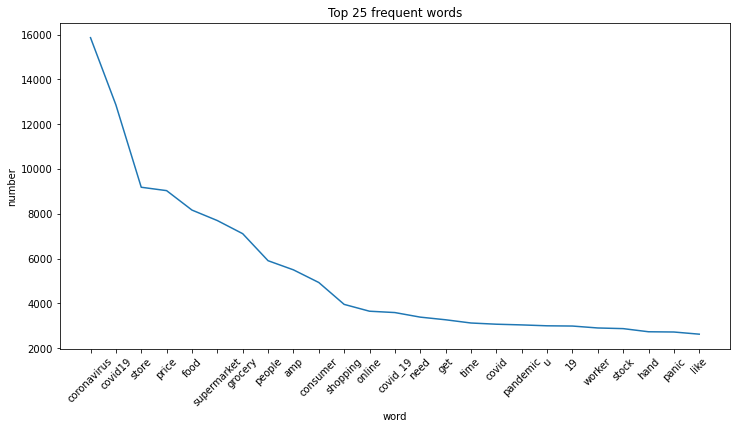

In [10]:
#Check top 25 frequent words
series = pd.Series("".join(combined_df['OriginalTweet']).split()).value_counts()[:25]
plt.figure(figsize = (12,6))
plt.xticks(rotation = '45')
plt.ylabel('number')
plt.xlabel('word')
plt.title('Top 25 frequent words')
plt.plot(series.index, series.values)

In [14]:
#Check how label number goes as time goes by
new_df = combined_df.copy()
new_df.head()
new_df.groupby(['TweetAt'])
new_df['TweetAt'] = pd.to_datetime(new_df['TweetAt'])
new_df.index = new_df['TweetAt']

unique_time = new_df['TweetAt'].unique()
plt.figure(figsize=(12,6))
for i in range(0,len(unique_time)):
    check_time = new_df[new_df['TweetAt'] == unique_time[i]]
    check_label_pos_num = len(check_time[check_time['sentiment_label'] == 'pos'])
    check_label_neg_nun = len(check_time[check_time['sentiment_label'] == 'neg'])
    plt.bar(check_time.index, check_label_pos_num, color = 'b',width = 5, label = 'positive')
    plt.bar(check_time.index,check_label_neg_nun, color = 'r',width = 2.5, label = 'negative', alpha = 0.7)


# Feature engineering

In [4]:
#I'm going to use TF-IDF in this section
#First we need to split the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(combined_df['OriginalTweet'],
                                                     combined_df['sentiment_label'], 
                                                    test_size=0.25, random_state=42)

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

In [5]:
#Count vector
vect_count = CountVectorizer().fit(X_train)
X_train_vect_count = vect_count.fit_transform(X_train)
X_test_vect_count = vect_count.fit_transform(X_test)

In [6]:
#Convert X_train and X_test into tfidf feature vector (word level)
tfidf_vectorizer_word = TfidfVectorizer().fit(X_train)
X_train_tfidf_word = tfidf_vectorizer_word.transform(X_train)
X_test_tfidf_word = tfidf_vectorizer_word.transform(X_test)

In [7]:
#Conver X_trian and X_test into n-gram tfidf 
tfidf_n_gram = TfidfVectorizer(ngram_range=(3,3)).fit(X_train)
X_train_tfidf_ngram = tfidf_n_gram.transform(X_train)
X_test_tfidf_ngram = tfidf_n_gram.transform(X_test)

In [8]:
#Convert X_train and X_test into tfidf feature vector (char level)
tfidf_vectorizer_char = TfidfVectorizer(analyzer='char', ngram_range=(3,3)).fit(X_train)
X_train_tfidf_char = tfidf_vectorizer_char.transform(X_train)
X_test_tfidf_char = tfidf_vectorizer_char.transform(X_test)

# Naive Bayes Classification

In [10]:
#char level
nb_char = MultinomialNB().fit(X_train_tfidf_char, y_train)
nb_char_prediction = nb_char.predict(X_test_tfidf_char)
accuracy_score(nb_char_prediction, y_test)

0.703061042890194

In [11]:
#word level
nb_word = MultinomialNB().fit(X_train_tfidf_word, y_train)
nb_word_prediction = nb_word.predict(X_test_tfidf_word)
accuracy_score(nb_word_prediction, y_test)

0.7790532123153586

In [12]:
#n-gram
nb_ngram = MultinomialNB().fit(X_train_tfidf_ngram, y_train)
nb_ngram_prediction = nb_ngram.predict(X_test_tfidf_ngram)
accuracy_score(nb_ngram_prediction, y_test)

0.6397045737675743

# Random forest classification

In [ ]:
#char level
RF_char = RandomForestClassifier().fit(X_train_tfidf_char,y_train)
cross_val_score(RF_char, X_test_tfidf_char , y_test, cv = 5,n_jobs=-1).mean()

In [ ]:
#word level
RF_word = RandomForestClassifier().fit(X_train_tfidf_word,y_train)
cross_val_score(RF_word,  X_test_tfidf_word, y_test, n_jobs=-1).mean()

In [ ]:
#n gram
RF_n_gram = RandomForestClassifier().fit(X_train_tfidf_ngram, y_train)
cross_val_score(RF_word,  X_test_tfidf_ngram, y_test, n_jobs=-1).mean()

In [ ]:
#vector count
RF_vect_count = RandomForestClassifier().fit(X_train_vect_count,y_train)
cross_val_score(RF_vect_count, X_test_vect_count, y_test, n_jobs=-1).mean()